In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

# Select nbody6 simulation and snapshot, then convert to physical units and save as a cluster table which SPISEA can interface with

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass             e                log_a               age        
------------------- ---------- --------------------- ------------------- ------------------ ------------------ ------------------
  56.24521950614411        0.0                    []   56.24521950614411                nan                nan  1.494411190854979
0.11411525852041825        0.0                    [] 0.11411525852041825                nan                nan 1.5011385289993755
  12.96283688892593        0.0                    []   12.96283688892593                nan                nan 1.4970749668953602
0.27321673034539384        0.0                    [] 0.27321673034539384                nan                nan 1.4964816285263873
                ...        ...                   ...                 ...                ...                ...                ...
0.20449300038109305        1.0 [0.11248395795903553] 0.31697695834012857   0.2989732941710

# Read ages of stars, identify bracketing ages for isochrone generation
Also save mass of stars

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.172382928762329
Max log age = 6.182058450993647
Min level age = 1487246.4082493563
Max level age = 1520752.191543579


# Identify binary stars in cluster table, save mass of companion stars

Cluster table always lists binaries last, so finding the index of the first binary suffices

In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
# print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
# print(compMasses)

# Create histogram of mass ratios pre-processing

(array([  3.,  14.,  69., 121., 181., 124., 134., 141., 120., 132.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 20 artists>)

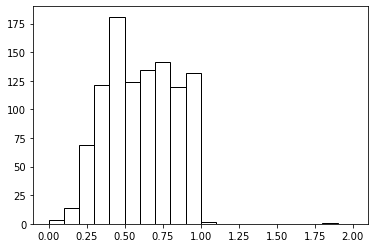

In [17]:
ratios = []
for i in range(len(compMasses)):
    ratios.append(compMasses[i] / masses[i + first_binary])
    # print(ratios[i])

py.hist(ratios, bins=20, range=[0, 2], fill=False)

# Generate isochrones using parameter and age arrays

In [7]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [8]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


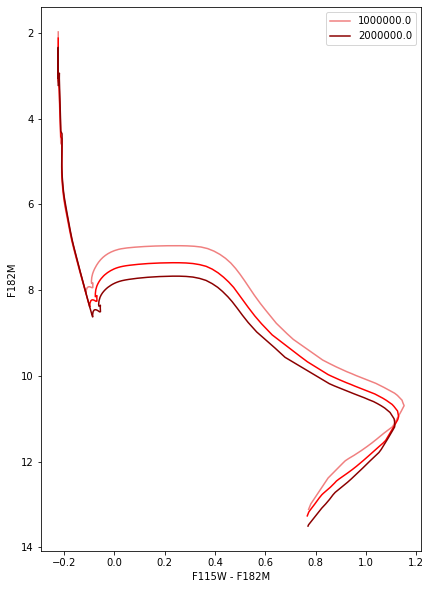

In [9]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# Use generated SPISEA isochrones to find interpolated magnitudes using the age and mass of each star

Stars outside of the mass range of isochrones are thrown out and not included

In [20]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
# for i in range(len(stars)):
    # print(stars[i])

Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.07746465814392134 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08466339817270757 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.08217508690946722 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.09649129577108034 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.0428821459115702 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.09262585734238067 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isochrone.
Desired mass 0.07831495046053252 is outside the range of the isoch

Desired mass 0.06898565680500175 is outside the range of the isochrone.
Desired mass 0.06898565680500175 is outside the range of the isochrone.
Desired mass 0.05958520059508319 is outside the range of the isochrone.
Desired mass 0.05958520059508319 is outside the range of the isochrone.
Desired mass 0.08504483371356775 is outside the range of the isochrone.
Desired mass 0.08504483371356775 is outside the range of the isochrone.
Desired mass 0.0424017446739525 is outside the range of the isochrone.
Desired mass 0.0424017446739525 is outside the range of the isochrone.
Desired mass 0.04805152490735054 is outside the range of the isochrone.
Desired mass 0.04805152490735054 is outside the range of the isochrone.
Desired mass 0.021330322098707468 is outside the range of the isochrone.
Desired mass 0.021330322098707468 is outside the range of the isochrone.
Desired mass 0.043282901343875496 is outside the range of the isochrone.
Desired mass 0.043282901343875496 is outside the range of the i

Desired mass 0.04277442332949356 is outside the range of the isochrone.
Desired mass 0.04277442332949356 is outside the range of the isochrone.
Desired mass 0.043328760959290266 is outside the range of the isochrone.
Desired mass 0.043328760959290266 is outside the range of the isochrone.
Desired mass 0.05846400931477547 is outside the range of the isochrone.
Desired mass 0.05846400931477547 is outside the range of the isochrone.
Desired mass 0.051996480723325245 is outside the range of the isochrone.
Desired mass 0.051996480723325245 is outside the range of the isochrone.
Desired mass 0.0575638302033674 is outside the range of the isochrone.
Desired mass 0.0575638302033674 is outside the range of the isochrone.
Desired mass 0.030150366947054863 is outside the range of the isochrone.
Desired mass 0.030150366947054863 is outside the range of the isochrone.
Desired mass 0.0289367591655904 is outside the range of the isochrone.
Desired mass 0.0289367591655904 is outside the range of the i

Desired mass 0.09177904606870409 is outside the range of the isochrone.
Desired mass 0.09177904606870409 is outside the range of the isochrone.
Desired mass 0.07996636873917212 is outside the range of the isochrone.
Desired mass 0.07996636873917212 is outside the range of the isochrone.
Desired mass 0.04829019644866959 is outside the range of the isochrone.
Desired mass 0.04829019644866959 is outside the range of the isochrone.
Desired mass 0.10023665718646409 is outside the range of the isochrone.
Desired mass 0.10023665718646409 is outside the range of the isochrone.
Desired mass 0.054928203638040365 is outside the range of the isochrone.
Desired mass 0.054928203638040365 is outside the range of the isochrone.
Desired mass 0.020009032647517896 is outside the range of the isochrone.
Desired mass 0.020009032647517896 is outside the range of the isochrone.
Desired mass 0.014163223822140176 is outside the range of the isochrone.
Desired mass 0.014163223822140176 is outside the range of t

Desired mass 0.028220353188508927 is outside the range of the isochrone.
Desired mass 0.028220353188508927 is outside the range of the isochrone.
Desired mass 0.054823568110513435 is outside the range of the isochrone.
Desired mass 0.054823568110513435 is outside the range of the isochrone.
Desired mass 0.030154807021412506 is outside the range of the isochrone.
Desired mass 0.030154807021412506 is outside the range of the isochrone.
Desired mass 0.029016829327417126 is outside the range of the isochrone.
Desired mass 0.029016829327417126 is outside the range of the isochrone.
Desired mass 0.057873400277110645 is outside the range of the isochrone.
Desired mass 0.057873400277110645 is outside the range of the isochrone.
Desired mass 0.09283551909580369 is outside the range of the isochrone.
Desired mass 0.09283551909580369 is outside the range of the isochrone.
Desired mass 0.04049817753144896 is outside the range of the isochrone.
Desired mass 0.04049817753144896 is outside the range 

Desired mass 0.0254156009506144 is outside the range of the isochrone.
Desired mass 0.0254156009506144 is outside the range of the isochrone.
Desired mass 0.09862312941844129 is outside the range of the isochrone.
Desired mass 0.09862312941844129 is outside the range of the isochrone.
Desired mass 0.06864934876118602 is outside the range of the isochrone.
Desired mass 0.06864934876118602 is outside the range of the isochrone.
Desired mass 0.09912453738708661 is outside the range of the isochrone.
Desired mass 0.09912453738708661 is outside the range of the isochrone.
Desired mass 0.030788843415302136 is outside the range of the isochrone.
Desired mass 0.030788843415302136 is outside the range of the isochrone.
Desired mass 0.03390163551254083 is outside the range of the isochrone.
Desired mass 0.03390163551254083 is outside the range of the isochrone.
Desired mass 0.051497568831153404 is outside the range of the isochrone.
Desired mass 0.051497568831153404 is outside the range of the i

Desired mass 0.031073097814164636 is outside the range of the isochrone.
Desired mass 0.031073097814164636 is outside the range of the isochrone.
Desired mass 0.02916019451341792 is outside the range of the isochrone.
Desired mass 0.02916019451341792 is outside the range of the isochrone.
Desired mass 0.07637162108734069 is outside the range of the isochrone.
Desired mass 0.07637162108734069 is outside the range of the isochrone.
Desired mass 0.06812822863648808 is outside the range of the isochrone.
Desired mass 0.06812822863648808 is outside the range of the isochrone.
Desired mass 0.010755127146363896 is outside the range of the isochrone.
Desired mass 0.010755127146363896 is outside the range of the isochrone.
Desired mass 0.010324322758555307 is outside the range of the isochrone.
Desired mass 0.010324322758555307 is outside the range of the isochrone.
Desired mass 0.07038695012093045 is outside the range of the isochrone.
Desired mass 0.07038695012093045 is outside the range of t

Desired mass 0.09377154802542306 is outside the range of the isochrone.
Desired mass 0.09377154802542306 is outside the range of the isochrone.
Desired mass 0.017598880682977713 is outside the range of the isochrone.
Desired mass 0.017598880682977713 is outside the range of the isochrone.
Desired mass 0.059014562517404556 is outside the range of the isochrone.
Desired mass 0.059014562517404556 is outside the range of the isochrone.
Desired mass 0.02552481263839769 is outside the range of the isochrone.
Desired mass 0.02552481263839769 is outside the range of the isochrone.
Desired mass 0.06647137901961056 is outside the range of the isochrone.
Desired mass 0.06647137901961056 is outside the range of the isochrone.
Desired mass 0.06120943650006553 is outside the range of the isochrone.
Desired mass 0.06120943650006553 is outside the range of the isochrone.
Desired mass 0.028197538797742845 is outside the range of the isochrone.
Desired mass 0.028197538797742845 is outside the range of t

Desired mass 0.031791702328048045 is outside the range of the isochrone.
Desired mass 0.031791702328048045 is outside the range of the isochrone.
Desired mass 0.02726709423245245 is outside the range of the isochrone.
Desired mass 0.02726709423245245 is outside the range of the isochrone.
Desired mass 0.022578710394293044 is outside the range of the isochrone.
Desired mass 0.022578710394293044 is outside the range of the isochrone.
Desired mass 0.04700913295414384 is outside the range of the isochrone.
Desired mass 0.04700913295414384 is outside the range of the isochrone.
Desired mass 0.1023343928940826 is outside the range of the isochrone.
Desired mass 0.1023343928940826 is outside the range of the isochrone.
Desired mass 0.06739850922114254 is outside the range of the isochrone.
Desired mass 0.06739850922114254 is outside the range of the isochrone.
Desired mass 0.09746280039544065 is outside the range of the isochrone.
Desired mass 0.09746280039544065 is outside the range of the i

Desired mass 0.034037607326690006 is outside the range of the isochrone.
Desired mass 0.021124462957848537 is outside the range of the isochrone.
Desired mass 0.021124462957848537 is outside the range of the isochrone.
Desired mass 0.033591525593399126 is outside the range of the isochrone.
Desired mass 0.033591525593399126 is outside the range of the isochrone.
Desired mass 0.10312155095152956 is outside the range of the isochrone.
Desired mass 0.08771075162708657 is outside the range of the isochrone.
Desired mass 0.08771075162708657 is outside the range of the isochrone.
Desired mass 0.09188052002390547 is outside the range of the isochrone.
Desired mass 0.09188052002390547 is outside the range of the isochrone.
Desired mass 0.10178586462094914 is outside the range of the isochrone.
Desired mass 0.10178586462094914 is outside the range of the isochrone.
Desired mass 0.06961573392078386 is outside the range of the isochrone.
Desired mass 0.06961573392078386 is outside the range of th

Desired mass 0.021491099638601362 is outside the range of the isochrone.
Desired mass 0.021491099638601362 is outside the range of the isochrone.
Desired mass 0.05118833750719928 is outside the range of the isochrone.
Desired mass 0.05118833750719928 is outside the range of the isochrone.
Desired mass 0.03783139538760416 is outside the range of the isochrone.
Desired mass 0.03783139538760416 is outside the range of the isochrone.
Desired mass 0.016854329283512118 is outside the range of the isochrone.
Desired mass 0.016854329283512118 is outside the range of the isochrone.
Desired mass 0.05388587290496008 is outside the range of the isochrone.
Desired mass 0.05388587290496008 is outside the range of the isochrone.
Desired mass 0.020374333670409698 is outside the range of the isochrone.
Desired mass 0.020374333670409698 is outside the range of the isochrone.
Desired mass 0.011291630830548679 is outside the range of the isochrone.
Desired mass 0.011291630830548679 is outside the range of

Desired mass 0.06306248861694883 is outside the range of the isochrone.
Desired mass 0.06306248861694883 is outside the range of the isochrone.
Desired mass 0.041299293155914296 is outside the range of the isochrone.
Desired mass 0.041299293155914296 is outside the range of the isochrone.
Desired mass 0.08809245980069288 is outside the range of the isochrone.
Desired mass 0.08809245980069288 is outside the range of the isochrone.
Desired mass 0.031385880212866944 is outside the range of the isochrone.
Desired mass 0.031385880212866944 is outside the range of the isochrone.
Desired mass 0.0955501279150732 is outside the range of the isochrone.
Desired mass 0.0955501279150732 is outside the range of the isochrone.
Desired mass 0.08849064767565185 is outside the range of the isochrone.
Desired mass 0.08849064767565185 is outside the range of the isochrone.
Desired mass 0.07266317020334916 is outside the range of the isochrone.
Desired mass 0.07266317020334916 is outside the range of the i

Desired mass 0.10190177802289548 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the isochrone.
Desired mass 0.013943339777357447 is outside the range of the isochrone.
Desired mass 0.013943339777357447 is outside the range of the isochrone.
Desired mass 0.04231069763318475 is outside the range of the isochrone.
Desired mass 0.04231069763318475 is outside the range of the isochrone.
Desired mass 0.05445120441756373 is outside the range of the isochrone.
Desired mass 0.05445120441756373 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the isochrone.
Desired mass 0.05962385167307392 is outside the range of the i

# Repeat interpolation on companion stars

Companion stars assumed to be the same age as primary star within system

In [21]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun
    
count = 0
for i in range(len(companions)):
    if companions[i] is None:
        count = count + 1
        continue
    print(companions[i])

print(count)
print(len(companions))


Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.09636490446440792 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.07471903553293849 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.05549755459546917 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.09389877662294215 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.10166459547430746 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.09223736189469771 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the isochrone.
Desired mass 0.08370963329421344 is outside the range of the iso

# Determine mass ratios after filtering, create plots

In [22]:
new_ratios = []
for i in range(len(companions)):
    if companions[i] is None:
        continue
    new_ratios.append(compMasses[i] / masses[i + first_binary])


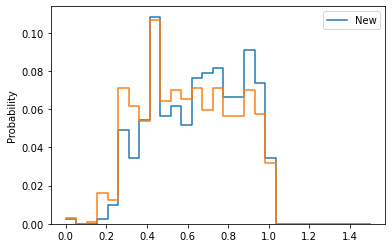

In [23]:
import seaborn as sns

bins = np.linspace(0, 1.5, 30)

sns.histplot(new_ratios, bins=bins, stat='probability', element='step', cumulative=False, fill=False, label="New")
sns.histplot(ratios, bins=bins, stat='probability', element='step', cumulative=False, fill=False)
plt.legend()

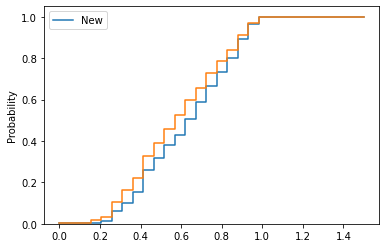

In [24]:
sns.histplot(new_ratios, bins=bins, stat='probability', element='step', cumulative=True, fill=False, label="New")
sns.histplot(ratios, bins=bins, stat='probability', element='step', cumulative=True, fill=False)
plt.legend()

# Superimpose primary stars and companion stars against isochrones separately

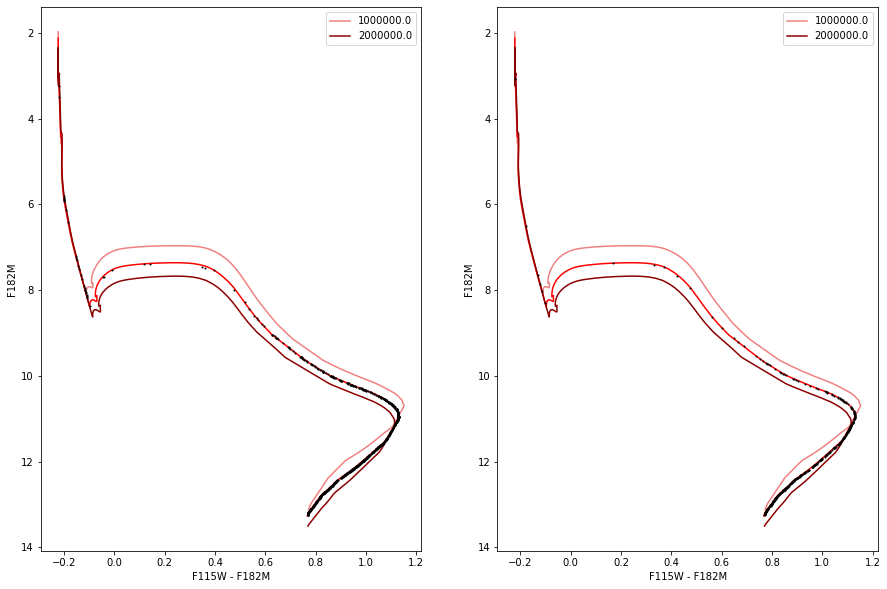

In [25]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# Convert binary stars into unresolved binaries
## Also compute flux ratios of stars and generate histogram
Magnitudes of primary and secondary are converted into flux, which is used to find combined magnitude

In [28]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

flux_ratios = []

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    flux_ratios.append(flux11 / flux21)
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 7.44e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 7.44e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 7.44e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

(array([  0.,   3.,   2., 129.,  81.,  47.,  30.,  34.,  13.,  15.,  17.,
          7.,   8.,   5.,   2.,   4.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.]),
 array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
         1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
         3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
         5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
         6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
         8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
        10.        ]),
 <BarContainer object of 30 artists>)

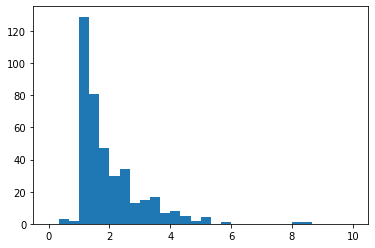

In [29]:
py.hist(flux_ratios, bins=30, range=[0,10])

# Generate CMD using star array, plus unresolved binaries
Compare to CMD generated by simply multiplying each star's flux by 2

In [ ]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(unresolved_binaries[i][0] - unresolved_binaries[i][1], unresolved_binaries[i][1], marker='o', markersize=1, color='k')
    
# plot toy scalar multiple track
py.subplot(1, 2, 2)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
for i in range(len(stars)):
    if stars[i] is None:
        continue
    x = -2.5 * np.log10(2 * np.power(10, stars[i][4] / -2.5))
    py.plot(stars[i][3] - stars[i][4], x, marker='o', markersize=1, color='k')